In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import skimage as sk
import os
from PIL import Image
from numpy import random
import cv2
import io
import torchvision
from torchvision import transforms

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import OneCycleLR
import tarfile

max_split_size_mb:512


In [4]:


def load_images(root_directory):
    images = []
    labels = []

    for root, dirs, files in os.walk(root_directory):
        for file in files:
            if file.lower().endswith('.jpg') and not file.lower().startswith('mask'):
                file_path = os.path.join(root, file)
                
                img = Image.open(file_path)
                img = img.resize((64,64))
                img = np.asarray(img, dtype=np.float32)
                img = img /255
                img = np.transpose(img,(2,0,1))
                images.append(img)

            if file.lower().endswith('.jpg') and file.lower().startswith('mask'):
                file_path = os.path.join(root, file)
                
                label = Image.open(file_path)
                label = label.resize((64,64))
                labels.append(label)
                
    return images, labels




In [5]:
ims, lbs = load_images("Train_Data")

In [6]:
ims = np.stack(ims, axis=0)
labels = np.stack(lbs, axis=0)
print(ims.shape)

(81, 3, 64, 64)


In [7]:
class CatTransforms:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomAffine(degrees=22, translate=(0.2, 0.2), scale=(0.85, 1.15)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ])
        
    def __call__(self, image, label):
        seed = torch.randint(0, 2**32, (1,)).item()
        
        torch.manual_seed(seed)
        transformed_image = self.transforms(image)
        
        torch.manual_seed(seed)
        transformed_label = self.transforms(label)
        
        return transformed_image, transformed_label

In [8]:
class CatDataSet(Dataset):
    def __init__(self, ims, labels, transforms):
        self.ims = torch.tensor(ims.astype(np.float32), dtype=torch.float32)
        self.labels = torch.tensor(labels.astype(np.float32), dtype=torch.float32)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.ims)
    
    
    def __getitem__(self, idx):
        
        image = self.ims[idx]
        label = self.labels[idx]
        label = label.unsqueeze(0)
        if self.transforms is not None:
            image, label = self.transforms(image, label)
        label = label.squeeze()
        return image, label
        
    

In [9]:
cat_transforms = CatTransforms()
split1 = int(ims.shape[0]*0.8)

train_set = CatDataSet(ims[:split1], labels[:split1], cat_transforms)
val_set = CatDataSet(ims[split1:], labels[split1:], None)

train_dataloader = DataLoader(train_set, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=10, shuffle=True)


In [ ]:
class ConvolutionBlock(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv_layers(x)


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.conv = ConvolutionBlock(in_channels, out_channels)
        self.mpool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        skip = self.conv(x)
        out = self.mpool(skip)
        return skip, out


def center_crop(layer, target_height, target_width):

    _, _, layer_height, layer_width = layer.size()
    diff_y = (layer_height - target_height) // 2
    diff_x = (layer_width - target_width) // 2
    return layer[:, :, diff_y : (diff_y + target_height), diff_x : (diff_x + target_width)]


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = ConvolutionBlock(out_channels + out_channels, out_channels)

    def forward(self, x, skip):
        out = self.up_conv(x)
        if out.size(2) != skip.size(2) or out.size(3) != skip.size(3):
            skip = center_crop(skip, out.size(2), out.size(3))
        out = torch.cat([out, skip], axis=1)
        out = self.conv(out)
        return out


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):

        super().__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.e1 = EncoderBlock(in_channels, 8)
        self.e2 = EncoderBlock(8, 16)
        self.e3 = EncoderBlock(16, 32)
        self.b = ConvolutionBlock(32, 64)
        self.d2 = DecoderBlock(64, 32)
        self.d3 = DecoderBlock(32, 16)
        self.d4 = DecoderBlock(16, 8)
        self.output = nn.Conv2d(8, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        skip1, out = self.e1(x)
        skip2, out = self.e2(out)
        skip3, out = self.e3(out)

        out = self.b(out)
        out = self.d2(out, skip3)
        out = self.d3(out, skip2)
        out = self.d4(out, skip1)
        out = self.output(out)
        return out

    def predict(self, x):
        out = self.forward(x)
        if self.out_channels == 1:
            out = torch.sigmoid(out)
        elif self.out_channels > 1:
            out = torch.softmax(out)
        return out

In [21]:
def train(model, train_dataloader, val_dataloader, optimizer,scheduler, loss_fn, n_epochs=10, delta=0.01, patience=10):
  train_losses = []
  val_losses = []

  best_loss = np.inf
  no_improvement_count = 0

  for epoch in range(n_epochs):
    model.train()
    train_epoch_losses = []

    for x, y in train_dataloader:
      optimizer.zero_grad()
      y_hat = model(x)
      y_hat = torch.squeeze(y_hat)
      y = torch.squeeze(y)
      loss = loss_fn(y_hat, y)
      train_epoch_losses.append(loss)
      loss.backward()
      optimizer.step()

    train_epoch_losses = torch.tensor(train_epoch_losses)
    avg_epoch_loss = train_epoch_losses.mean()
    train_losses.append(avg_epoch_loss)

    model.eval()
    val_epoch_losses = []

    for x, y in val_dataloader:
      with torch.no_grad():
        y_hat = model(x)
      y_hat = torch.squeeze(y_hat)
      y = torch.squeeze(y)
      loss = loss_fn(y_hat, y)
      val_epoch_losses.append(loss)

    val_epoch_losses = torch.tensor(val_epoch_losses)
    avg_epoch_loss = val_epoch_losses.mean()
    val_losses.append(avg_epoch_loss)

    print(f'Tranining {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')
    
  return train_losses, val_losses

In [22]:
lr = 0.000000001
cat_model = UNET()
optimizer = torch.optim.AdamW(cat_model.parameters(), lr=lr)

loss_fn = nn.BCEWithLogitsLoss()
train_losses, val_losses = train(cat_model, train_dataloader, val_dataloader, optimizer, None, loss_fn, 700)

Tranining 1/700 done, training loss: -24.229480743408203, validation loss: -26.920368194580078
Tranining 2/700 done, training loss: -24.13474464416504, validation loss: -26.982139587402344
Tranining 3/700 done, training loss: -24.175539016723633, validation loss: -27.579082489013672
Tranining 4/700 done, training loss: -24.3435001373291, validation loss: -27.93310546875
Tranining 5/700 done, training loss: -23.81010627746582, validation loss: -26.5748291015625
Tranining 6/700 done, training loss: -24.324779510498047, validation loss: -26.987831115722656
Tranining 7/700 done, training loss: -24.602176666259766, validation loss: -26.99687385559082
Tranining 8/700 done, training loss: -24.40097427368164, validation loss: -26.5771541595459
Tranining 9/700 done, training loss: -24.271514892578125, validation loss: -27.324390411376953
Tranining 10/700 done, training loss: -24.130151748657227, validation loss: -26.684009552001953
Tranining 11/700 done, training loss: -24.411300659179688, vali

KeyboardInterrupt: 

0.81402475


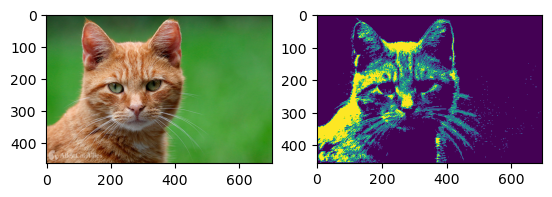

In [27]:
img = np.asarray(Image.open("FELV-cat.jpg"), dtype=np.int32)
tensor_img = torch.tensor(img, dtype=torch.float32)
tensor_img = tensor_img.permute(2,0,1).unsqueeze(0)
tensor_img = cat_model.predict(tensor_img).squeeze()
cat_imazs = np.asarray(tensor_img.detach())
treshhold = (np.max(cat_imazs))
print(treshhold)
cat_imazs = np.where(cat_imazs < 0.64, 0, 1)
f, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(cat_imazs)